In [11]:
import numpy as np
import scipy as sc
from iminuit import Minuit
import pandas as pd
import scipy.interpolate as interpolate
from scipy.integrate import quad
from matplotlib import colors
from EBL_MC_final_functions_local import *
from scipy.stats import norm
from scipy.stats import poisson
import yaml
import matplotlib.pyplot as plt
import h5py
import time
import sys
import os
import uproot
from scipy.stats import norm, chi2
from pathlib import Path
from ebltable.tau_from_model import OptDepth

In [82]:
#Source info
extratxt = "test_systematics"
Systematics = True
sys_err = 0.07#0.0225
allsources = np.array([
    "Mrk421_20130410", "Mrk421_20130411", "Mrk421_20130412", "Mrk421_20130413a", "Mrk421_20130413b", "Mrk421_20130413c",
    "Mrk421_20130414", "Mrk421_20130415a", "Mrk421_20130415b", "Mrk421_20130415c", "Mrk421_20130416", "Mrk421_20130417",
    "Mrk421_20130418", "Mrk421_20130419", "Mrk421_20140426", "1ES1959+650_2015", "ot546_Oct2015", "BLLac_20150615", 
    "1ES0229+200", "1ES1011_Feb2014", "PKS1510-089_May2015", "PKS1510-089_31May2016", "PKS1222+216_June2010", "PG1553_ST0202",
    "PG1553_ST0203", "PG1553_ST0302", "PG1553_ST0303", "PG1553_ST0306", "PKS1424_2014", "PKS1424_2015", "PKS1441+25_2015", "B0218_2014"
    ])

number = 19
Source_name = allsources[number] #'PG1553_ST0203' "1ES1011_Feb2014", 'Mrk421_20130415c', #Check that you have all needed files before running
# Observation_time = 42480 #this is only needed for CTA
#REPEAT 18 as its the one with problematic data. (22 in the fitebl file) also 29, 30
#Source_name = "BLLac_2020"
Mrk421_eminemax = np.array([[0.062, 9.],
                            [0.046, 16.],
                            [0.046, 16.],
                            [0.046, 16.],
                            [0.046, 16.],
                            [0.086, 16.],
                            [0.046, 16.],
                            [0.046, 16.],
                            [0.046, 12.],
                            [0.06, 16.],
                            [0.046, 16.],
                            [0.046, 16.],
                            [0.06, 16.],
                            [0.115, 16.],
                            [0.06, 16.]])
Mrk421_func = np.array(["LP", "SEPWL", "EPWL", "EPWL", "ELP", "ELP", "ELP", "EPWL", "SEPWL", "ELP", "ELP", "LP", "EPWL", "LP", "EPWL"])

Emin, Emax =  0.06, 20 #Mrk421_eminemax[number]#0.06, 16. # 0.058#0.059

# Emax = 6.#20.1 #15.
betterEminmax = False
#Fit function: PWL, LP, freeLP or MBPWL
fit_func_name = "LP" #Mrk421_func[number]#"ELP"

if "Mrk421" in Source_name:
    Source_z = 0.03
if "1ES1011" in Source_name:
    Source_z = 0.212
if "PG1553" in Source_name:
    Source_z = 0.43
if "BLLac" in Source_name:
    Source_z = 0.069
if "1ES1959" in Source_name:
    Source_z = 0.048
if "1ES0229" in Source_name:
    Source_z = 0.14
if "ot546" in Source_name:
    Source_z = 0.055
if "PKS1510" in Source_name:
    Source_z = 0.361
if "PKS1222" in Source_name:
    Source_z = 0.432
if "PKS1441" in Source_name:
    Source_z = 0.939
if "PKS1424" in Source_name:
    Source_z = 0.604
if "B0218" in Source_name:
    Source_z = 0.944

#Telescope
Telescope = "MAGIC" #only MAGIC is well implemented now
#EBL options
EBL_Model = "dominguez" #there is only one a the moment
scan_method = 5 # 0 for normal scanning, 1 for scanning and retryng failed fits, 2 for scanning and scanning again with another initial guess, 3 for scanning, retrying failed fits and 
                #scanning again with another initial guess and 4 for doing every alpha by itself (no chained initial guess) Like 3 but doing everything ant taking the best even if it does not fail
                #FIXME 5 not working as I want.
alpha_step = 0.01 #EBL scale bin size
alpha_init = 0.0-alpha_step #positon of the first initial guess. used in scan_method 0, 1, 2 and 3   
other_initial_guess_position = 2.0+alpha_step #this is only used for non converging fits in scan_method 2 and 3
alpha_min = 0.0-alpha_step #lowest EBL scale factor
alpha_max = 2.0+alpha_step #hightes EBL scale factor
Chain_guess = True

IRF_u = True

#MBPWL info
Efirst = 0.1694 #0.379#0.389#0.143#0.11
DeltaE = 0.157#9.428#3.11#0.211#0.186
knots = 2 #number of knots in the MBPWL

#Ohter options
Background_scale = 1.
Forward_folding = True #FIXME this makes no sense and should be remooved
migmatmaxu = 0.49 #maximum ratio between value and error in the migration matrix
Chain_guess = True
Norm = 0.249

In [83]:
if "Mrk421_2013" in Source_name:
    data_path = "/home/rgrau/Desktop/EBL_analysis_Feb2018/{0}/light+00/Output_flute.root".format(Source_name)#"/home/rgrau/Desktop/EBL_Gamma2016/EBL_samples/{0}/data/nominal/flute/Output_flute.root".format(Source_name)#"/home/rgrau/Desktop/EBL_Gamma2016/EBL_samples/Mrk421_20130415c/data/nominal/flute/Output_flute.root"
elif "PKS1510-089_31May2016" in Source_name:
    data_path = "/home/rgrau/Desktop/EBL_analysis_Feb2018/PKS1510-089_31May2016/data/nominal/flute/scale100/Output_flute.root"#"/home/rgrau/Desktop/EBL_Gamma2016/EBL_samples/{0}/data/nominal/flute/Output_flute.root".format(Source_name)#"/home/rgrau/Desktop/EBL_Gamma2016/EBL_samples/Mrk421_20130415c/data/nominal/flute/Output_flute.root"
elif "PKS1424_2015" in Source_name:
    data_path = "/home/rgrau/Desktop/EBL_analysis_Feb2018/PKS1424_2015/data/nominal/flute/scale100/Output_flute.root"#"/home/rgrau/Desktop/EBL_Gamma2016/EBL_samples/{0}/data/nominal/flute/Output_flute.root".format(Source_name)#"/home/rgrau/Desktop/EBL_Gamma2016/EBL_samples/Mrk421_20130415c/data/nominal/flute/Output_flute.root"
elif "BLLac_2020" in Source_name:
    data_path = "/home/rgrau/Desktop/EBL_analysis_Feb2018/BLLac2020/Output_flute_150_EPWL.root"
else:
    data_path = "/home/rgrau/Desktop/EBL_analysis_Feb2018/{0}/data/nominal/flute/Output_flute.root".format(Source_name)
alphas = alphas_creation(alpha_init, alpha_min, alpha_max, alpha_step)

fit_func = fit_func_select(fit_func_name, knots, Efirst, DeltaE)

if fit_func_name == "MBPWL":
    if Forward_folding:
        initial_guess_0 = np.zeros(knots+2)
        initial_guess_0[0] = 5e-6
        initial_guess_0[1] = 2.
    else:
        initial_guess_0 = np.zeros(knots+2)
        initial_guess_0[0] = 5e-6
        initial_guess_0[1] = 2.
elif fit_func_name == "PWL":
    if Forward_folding:
        initial_guess_0 = np.array([5e-6, 2.00])
    else:
        initial_guess_0 = np.array([5e-7, 2.]) #phi_0, gamma
elif fit_func_name == "LP":
    if Forward_folding:
        initial_guess_0 = np.array([5e-6, 2., 0.])
    else:
        initial_guess_0 = np.array([5e-7, 2., 0.]) #phi_0, alpha, beta
elif fit_func_name == "freeLP":
    if Forward_folding:
        initial_guess_0 = np.array([5e-6, 2., 0.])
    else:
        initial_guess_0 = np.array([5e-7, 2., 0.]) #phi_0, alpha, beta
elif fit_func_name == "EPWL":
        initial_guess_0 = np.array([5e-6, 2., np.sqrt(3.e4)]) #x[0] = 1.e-9; x[1] = -2.; x[2] = sqrt(3.e4)

elif fit_func_name == "ELP":
        initial_guess_0 = np.array([5e-6, 2., 0.15, np.sqrt(3.e4)]) #1.e-9; x[1] = -2.; x[2] = 0.15; x[3] = sqrt(3.e4)

elif fit_func_name == "SEPWL":
        initial_guess_0 = np.array([5e-6, 2., np.sqrt(3.e4), 1.]) #1.e-9; x[1] = -2.; x[2] = sqrt(3.e4); x[3] = 1.

elif fit_func_name == "SELP":
        initial_guess_0 = np.array([5e-6, 2., 0.15, np.sqrt(3e4), 1.]) #x[0] = 1.e-9; x[1] = -2.; x[2] = 0.15; x[3] = sqrt(3.e4); x[4] = 1.

# if Telescope == "CTAN_alpha": #this part needs to be changed to include the real CTAN_alpha configuration
#     Noffregions = 5
#     def m2LogL(params):
#         xdata = E_EBL
#         mtau = -tau
#         mu_gam0 = dNdE_to_mu((fit_func(xdata, params) * np.exp(mtau * alpha))[2:37], Effa_reb, Ebinsw[2:37], Observation_time, Ebins, Eres_reb2, E_EBL[2:37])
#         mu_gam = mu_gam0[5:-4]
#         mu_bg = mu_BG(mu_gam, Non, Noff, Noffregions)
#         min_num_gauss = 20
#         conditions = [((Non >= min_num_gauss) & (Noff >= min_num_gauss)), (Non == 0.), (Noff == 0.), (Non != 0.) & (Noff != 0.)]
#         choices = [Gauss_logL(Non, Noff, mu_gam, Noffregions), Poisson_logL_Non0(Non, Noff, mu_gam, Noffregions), Poisson_logL_Noff0(Non, Noff, mu_gam, Noffregions), Poisson_logL(Non, Noff, mu_gam, mu_bg, Noffregions)]
#         res = np.select(conditions, choices, default = 999999999)
#         return np.sum(res)
        
if Telescope == "MAGIC":
    Noffregions = 3
    def m2LogL(params):
        xdata = Etrue
        mtau = -tau
        if IRF_u:
            mu_gam, mu_gam_u = dNdE_to_mu_MAGIC_IRF((fit_func(xdata, params) * np.exp(mtau * alpha)), Ebinsw_Etrue, migmatval, migmaterr, Eest)
            if Systematics:
                mu_gam_u = np.sqrt(np.square(mu_gam_u) + np.square(sys_err * mu_gam))
            mu_gam_temp_u = mu_gam_u[minbin:maxbin]

        else:
            mu_gam = dNdE_to_mu_MAGIC((fit_func(xdata, params) * np.exp(mtau * alpha)), Ebinsw_Etrue, migmatval, Eest)

        mu_gam_temp = mu_gam[minbin:maxbin]
        Non_temp = Non[minbin:maxbin] 
        Noff_temp = Noff[minbin:maxbin]
        
        if betterEminmax:
            newminbin, newmaxbin = minbinmaxbinfinal(Non_temp, Noff_temp)
            Non_final = Non_temp[newminbin:newmaxbin]
            Noff_final = Noff_temp[newminbin:newmaxbin]
            mu_gam_final = mu_gam_temp[newminbin:newmaxbin]
            if IRF_u:
                mu_gam_final_u = mu_gam_temp_u[newminbin:newmaxbin]
        else: 
            Non_final = Non_temp
            Noff_final = Noff_temp
            mu_gam_final = mu_gam_temp
            if IRF_u:
                mu_gam_final_u = mu_gam_temp_u

        min_num_gauss = 20

        res = np.ones(len(Non_final)) * 999999999
        for i in range(len(Non_final)):
            if IRF_u:
                if ((Non_final[i] >= min_num_gauss) & (Noff_final[i] >= min_num_gauss)):
                    res[i] = Gauss_logL_IRF(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)
                elif Non_final[i] == 0:
                    res[i] = Poisson_logL_Non0_IRF(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)
                elif Noff_final[i] == 0:
                    res[i] = Poisson_logL_Noff0_IRF(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)
                elif mu_gam_final[i] < 1e-6:
                    res[i] = Poisson_logL_small_mugam_IRF(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)
                elif mu_gam_final_u[i] == 0:
                    res[i] = Poisson_logL_noIRF_IRF(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)
                elif (Non_final[i] != 0) & (Noff_final[i] != 0):
                    res[i] = Poisson_logL_else_IRF(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)
            
            else:
                if ((Non_final[i] >= min_num_gauss) & (Noff_final[i] >= min_num_gauss)):
                    res[i] = Gauss_logL(Non_final[i], Noff_final[i], mu_gam_final[i], Noffregions)
                elif Non_final[i] == 0:
                    res[i] = Poisson_logL_Non0(Non_final[i], Noff_final[i], mu_gam_final[i], Noffregions)
                elif Noff_final[i] == 0:
                    res[i] = Poisson_logL_Noff0(Non_final[i], Noff_final[i], mu_gam_final[i], Noffregions)
                elif (Non_final[i] != 0) & (Noff_final[i] != 0):
                    res[i] = Poisson_logL_else(Non_final[i], Noff_final[i], mu_gam_final[i], Noffregions) 

        return np.sum(res)

def fit(initial_guess):

    if fit_func_name == "MBPWL":
        if knots == 1:
            names = ("phi0", "gamma0", "Deltag0", "Eknot")
        else:
            names = ("phi0", "gamma0")
            for i in range(knots):
                names = names + ("Deltag{0}".format(i),)
    elif fit_func_name == "PWL":
        names = ("phi0", "gamma0")            
    elif fit_func_name == "LP" or fit_func_name == "freeLP":
        names = ("phi0", "gamma0", "b")
    elif fit_func_name == "EPWL":
        names = ("phi0", "gamma0", "Ecut")
    elif fit_func_name == "ELP":
        names = ("phi0", "gamma0", "b", "Ecut")
    elif fit_func_name == "SEPWL":
        names = ("phi0", "gamma0", "Ecut", "d")
    elif fit_func_name == "SELP":
        names = ("phi0", "gamma0", "b", "Ecut", "d")

    m2LogL.errordef = Minuit.LIKELIHOOD
    m = Minuit(m2LogL, initial_guess, name = names)   

    if fit_func_name == "MBPWL": #defines limits to faster and better find the minimum. Can be changed if the intrinsic spectrum function is changed. 
        MBPWL_limits = ([(1e-6, 1e-3), (-4., 5.)])
        errors = [1e-7, 0.01]
        for i in range(knots):
            MBPWL_limits.append(None)
            errors.append(0.01)
        m.limits = MBPWL_limits
    elif fit_func_name == "PWL":
        m.limits = ([(1e-7,1e-3), None]) #TODO canviar això al codi principal
        errors = [1e-7, 0.01]
    elif fit_func_name == "LP" or fit_func_name == "freeLP":
        m.limits = ([(1e-7, 1e-3), (None, None), (None, None)])
        errors = [1e-7, 0.01, 0.01]
    elif fit_func_name == "EPWL":
        m.limits = ([(1e-7, 1e-3), (None, None), (None, None)])
        errors = [1e-8, 1e-3, 1e-3]#[1e-8, 1.0, np.sqrt(500.)]
    elif fit_func_name == "ELP":
        m.limits = ([(1e-7, 1e-3), (-2., None), (None, None), (None, None)])
        errors = [1e-8, 1., 0.1, np.sqrt(500.)]
    elif fit_func_name == "SEPWL":
        m.limits = ([(1e-7, 1e-3), (None, None), (None, None), (None, None)])
        errors = [1e-8, 1.0, np.sqrt(500.), 1.]
        # m.fixed[3] = True
        # m.values[3] = 1.

    elif fit_func_name == "SELP":
        m.limits = ([(1e-7, 1e-3), (-2., None), (None, None), (None, None), (None, None)])
        errors = [1e-8, 1., 0.1, np.sqrt(500.), 0.1]
    # m.tol = 1e-6
    # m.strategy = 1
    m.errors = errors
     
    m.migrad()
    return m

# if EBL_Model == "Dominguez": #loads the EBL data of the Dominguez et al 2011 paper.
#     possible_z = np.array([0.01, 0.02526316, 0.04052632, 0.05578947, 0.07105263, 0.08631579, 0.10157895, 0.11684211, 0.13210526, 0.14736842, 0.16263158, 0.17789474, 0.19315789, 0.20842105, 0.22368421, 0.23894737, 0.25421053, 0.26947368, 0.28473684, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75])
#     closest_z = find_z(possible_z, Source_z)
#     file = np.loadtxt('/home/rgrau/Desktop/EBL-splines/tau_dominguez11.out')
#     pdfile = pd.DataFrame(file)
#     pdfile = pdfile.rename(columns={ 0 : 'E [TeV]', 1: 'tau z=0.01', 2: 'tau z=0.02526316', 3: 'tau z=0.04052632', 4: 'tau z=0.05578947', 5: 'tau z=0.07105263', 6: 'tau z=0.08631579', 7: 'tau z=0.10157895', 8: 'tau z=0.11684211', 9: 'tau z=0.13210526', 10: 'tau z=0.14736842', 11: 'tau z=0.16263158', 12: 'tau z=0.17789474', 13: 'tau z=0.19315789', 14: 'tau z=0.20842105', 15: 'tau z=0.22368421', 16: 'tau z=0.23894737', 17: 'tau z=0.25421053', 18: 'tau z=0.26947368', 19: 'tau z=0.28473684', 20: 'tau z=0.3' , 21: 'tau z=0.35', 22: 'tau z=0.4' , 23: 'tau z=0.45', 24: 'tau z=0.5', 25: 'tau z=0.55', 26: 'tau z=0.6', 27: 'tau z=0.65', 28: 'tau z=0.7' , 29: 'tau z=0.75'})
#     E_EBL = pdfile['E [TeV]'].to_numpy() #energy bins
#     tau_EBL = pdfile['tau z={0}'.format(closest_z)].to_numpy() #tau bins
# else:
#     raise Exception('The EBL model "{func}" has not been implemented.'.format(func = EBL_Model))

In [84]:
if Telescope == "MAGIC": #compute values needed for minimization if the selected telescope is MAGIC
    
    Bckg = uproot.open("{0}:hEstBckgE".format(data_path))#uproot.open(data_path + ":hEstBckgE")#load background values
    bckgmu_final = Bckg.values() #counts in 42480s (can be normalized for any time but as the migmatrix is for that time, only use that time).

    migrmatrix = uproot.open("/home/rgrau/Desktop/EBL-splines/fold_migmatrix_{0}.root:mig_matrix".format(Source_name))
    migmatval = migrmatrix.values() #m^2 * s #values
    if IRF_u:
        migmaterr = migrmatrix.errors()
        # migmatval[(migmaterr/migmatval)>migmatmaxu] = 0
        # migmaterr[(migmaterr/migmatval)>migmatmaxu] = 0
    migmatxEtrue = migrmatrix.axis("x").edges()/1e3 #TeV #edge values of X axis of the migration matrix (True Energy)
    migmatyEest = migrmatrix.axis("y").edges()/1e3 #TeV #edge values of Y axis of the migration matrix (Estimated Energy)

    Eest = migrmatrix.axis("y").centers()/1e3 #TeV #center values of X axis of the migration matrix (True Energy)
    Etrue = migrmatrix.axis("x").centers()/1e3 #TeV #center values of Y axis of the migration matrix (Estimated Energy)
    E_final = Etrue
    Usedbins = np.where((Emin <= Eest) & (Eest <= Emax))
    minbin = Usedbins[0][0]
    maxbin = Usedbins[0][-1] + 1
    Eest_final = Eest[minbin:maxbin]
    
    tau1 =  OptDepth.readmodel(model=EBL_Model)
    tau = tau1.opt_depth(Source_z, Etrue)
    # tau = tau_interp(Etrue, Source_z, EBL_Model, kind_of_interp = "log")#log_interp1d(E_EBL, tau_EBL, Etrue) #interpolate the tau values to have the same bins as the migration matrix and the data.
    Ebinsw_final = migmatyEest[1:] - migmatyEest[:-1] #compute the bin width of the final energy bins
    Ebinsw_Etrue = migmatxEtrue[1:] - migmatxEtrue[:-1] #compute the bin width of Etrue energy bins

    excess = uproot.open("/home/rgrau/Desktop/EBL-splines/excess_{0}.root:_px".format(Source_name))
    excess_events = excess.values() #Energy bins = Eest

    mu_vec_final = excess_events
    

In [85]:
def process2(alphas, mu_on, mu_off):
    chisqs = []
    chi_bf = 9999999
    chisqs = np.ones(len(alphas)) * 99999999
    global alpha, Non, Noff
    alpha = alpha_init
    Non, Noff = np.round(mu_on), np.round(Noffregions * mu_off)
    # print(Non, Noff)
    Non_u, Noff_u = np.sqrt(Non), np.sqrt(Noff)
    bestfit = initial_guess_0
    if scan_method == 4:
        for i, alpha0 in enumerate(alphas):
            alpha = alpha0
            things = fit(initial_guess = initial_guess_0)
            if things.valid == False:
                print("Function {0} did not minimize properly the {1} intrinsic spectra for alpha {2}".format(fit_func_name, Source_name, alpha))
            else:
                chi2 = m2LogL(things.values)
                chisqs[i] = chi2
                if chi_bf > chi2:
                    chi_bf = chi2
                    bestfit = things.values
    else:
        things = fit(initial_guess=initial_guess_0)
        initial_guess_mat = ig_mat_create(fit_func_name, alphas, knots)
        initial_guess_mat[0] = things.values
        for i, alpha0 in enumerate(alphas):
            # print("alpha:", alpha0)
            # print("initial guess:", initial_guess_mat[i])
            alpha = alpha0
            initial_guess = initial_guess_mat[i]
            if alpha == alpha_init:
                initial_guess = initial_guess_mat[0]
            things = fit(initial_guess = initial_guess)
            if i < len(alphas):
                initial_guess_mat[i+1] = things.values
            if things.valid == False:
                print("Function {0} did not minimize properly the {1} intrinsic spectra for alpha {2}".format(fit_func_name, Source_name, alpha))
            else:
                chi2 = m2LogL(things.values)
                chisqs[i] = chi2
                if chi_bf > chi2:
                    chi_bf = chi2
                    bestfit = things.values
                if alpha == 1 or alpha == 0.995:
                    print("alpha = 1 best fit: ", things.values)
                    bestfit_alpha1 = things.values
                    chialph1 = chi2

        if scan_method == 1 or scan_method == 3:
            for i, alpha0 in enumerate(reversed(alphas)):
                j = len(alphas) - i - 1
                if chisqs[j] == 99999999:
                    alpha = alpha0
                    if i == 0:
                        initial_guess = initial_guess_mat[0]
                    else:
                        initial_guess = initial_guess_mat[j+2]
                    print("Retrying alpha = {0} with different initial guess: {1}".format(alpha0, initial_guess))
                    things = fit(initial_guess = initial_guess)
                    if things.valid == False:
                        print("Function {0} did not minimize properly with the other initial guess".format(fit_func_name))
                        print("The initial guess was: ", initial_guess)
                        break
                    else:    
                        print("Function {0} minimized properly with the other initial guess".format(fit_func_name))
                        chi2 = m2LogL(things.values)
                        initial_guess_mat[j+1] = things.values
                        # print("chi2: ", chi2)
                        chisqs[j] = chi2 
                        if chi_bf > chi2:
                            chi_bf = chi2
                            bestfit = things.values
                        if alpha == 1 or alpha == 0.995:
                            print("alpha = 1 best fit: ", things.values)
                            bestfit_alpha1 = things.values
                            chialph1 = chi2
        elif scan_method == 5:
            for i, alpha0 in enumerate(reversed(alphas)):
                j = len(alphas) - i - 1
                alpha = alpha0
                if i == 0:
                    initial_guess = initial_guess_mat[0]
                else:
                    initial_guess = initial_guess_mat[j+2]
                # print("alpha:", alpha0)
                # print("initial guess:", initial_guess)   
                # print("Retrying alpha = {0} with different initial guess: {1}".format(alpha0, initial_guess))
                things = fit(initial_guess = initial_guess)
                if things.valid == False:
                    print("Function {0} did not minimize properly with the other initial guess for alpha {1}".format(fit_func_name, alpha))
                else:    
                    chi2 = m2LogL(things.values)
                    initial_guess_mat[j+1] = things.values
                    # print("chi2: ", chi2)
                    if chi2 < chisqs[j]:
                        chisqs[j] = chi2 
                        if chi_bf > chi2:
                            chi_bf = chi2
                            bestfit = things.values
                        if alpha == 1 or alpha == 0.995:
                            if chi2 < chialph1:
                                print("alpha = 1 best fit: ", things.values)
                                bestfit_alpha1 = things.values
                                chialph1 = chi2

                    
    return chisqs, bestfit, bestfit_alpha1, chialph1

mu_on = mu_vec_final + bckgmu_final
mu_off = bckgmu_final 
chisqs1, bestfit1, bestfit_alpha1_1, chialpha1 = process2(alphas, mu_on, mu_off)
if scan_method == 2 or scan_method == 3:
    if (chisqs1 == 99999999).any() or (chisqs1 == np.inf).any(): #if the first try did not work, we try to minimize it with another initial guess position
        # print("As function {0} did not minimize properly in the 2nd try with the other initial guess, we will try to minimize it with another initial guess position".format(fit_func_name))
        alphas2 = alphas_creation(other_initial_guess_position, alpha_min, alpha_max, alpha_step)
        chisqs2, bestfit2, bestfit_alpha1_2, chialpha2 = process2(alphas2, mu_on, mu_off)

        #need to reorder the vectors in order to have the same order as the one with the previous initial guess.
        #FIXME make all to go from 0 to max
        initial_pos = np.where(alphas == alphas2[0])[0][0]
        indices = np.argsort(alphas)
        index_init = np.where(indices == initial_pos)[0][0]
        chisqs2 = np.concatenate((chisqs2[indices[index_init:]], np.flip(chisqs2[indices[:index_init]])))
        chisqs = np.minimum(chisqs1, chisqs2)#make that if there is a nan use the other one
        #bestfit2 = np.concatenate((bestfit2[indices[index_init:]], np.flip(bestfit2[indices[:index_init]])))
        bestfit_alpha1 = bestfit_alpha1_1 if chialpha1 < chialpha2 else bestfit_alpha1_2
        bestfit = bestfit1 if np.min(chisqs1) < np.min(chisqs2) else bestfit2
    else:
        chisqs = chisqs1
        bestfit = bestfit1

elif scan_method == 5:
    alphas2 = alphas_creation(other_initial_guess_position, alpha_min, alpha_max, alpha_step)
    chisqs2, bestfit2, bestfit_alpha1_2, chialpha2 = process2(alphas2, mu_on, mu_off)

    #need to reorder the vectors in order to have the same order as the one with the previous initial guess.
    #FIXME make all to go from 0 to max
    initial_pos = np.where(alphas == alphas2[0])[0][0]
    indices = np.argsort(alphas)
    index_init = np.where(indices == initial_pos)[0][0]
    chisqs2 = np.concatenate((chisqs2[indices[index_init:]], np.flip(chisqs2[indices[:index_init]])))
    chisqs = np.minimum(chisqs1, chisqs2)#make that if there is a nan use the other one
    #bestfit2 = np.concatenate((bestfit2[indices[index_init:]], np.flip(bestfit2[indices[:index_init]])))
    bestfit_alpha1 = bestfit_alpha1_1 if chialpha1 < chialpha2 else bestfit_alpha1_2
    bestfit = bestfit1 if np.min(chisqs1) < np.min(chisqs2) else bestfit2
             
else:
    chisqs = chisqs1
    bestfit = bestfit1

print(bestfit)
print("bestfit_alpha1: ", bestfit_alpha1)
hdf5filename = "chi2fits/chi2_{0}_{1}_{2}.hdf5".format(Source_name, fit_func_name, extratxt)
savefile = h5py.File(hdf5filename, "w")
order = np.argsort(alphas)
alphas2 = np.take_along_axis(alphas, order, axis=-1)[1:-1]
chisqs2 = np.take_along_axis(np.array(chisqs), order, axis=-1)[1:-1]
dset = savefile.create_dataset("alphas", data = alphas2, dtype='float')
dset = savefile.create_dataset("chisqs", data = chisqs2, dtype='float')
savefile.close()

/home/rgrau/Desktop/EBL_pic_sync/EBL_MC_final_functions_local.py:589: RuntimeWarning: divide by zero encountered in log
  chi2proxy[i] = -2*(np.log(poisson.pmf(Non, mu_bg2[i]+mu_gam2[i])) + np.log(poisson.pmf(Noff, mu_bg2[i]/fAlpha)) - 0.5*eps*eps)


alpha = 1 best fit:  <ValueView phi0=8.854514095987298e-06 gamma0=2.013413322859722 b=-0.20117927027629506>
alpha = 1 best fit:  <ValueView phi0=8.855024617186513e-06 gamma0=2.0133708438870173 b=0.20099624206801223>
alpha = 1 best fit:  <ValueView phi0=8.85502461718794e-06 gamma0=2.0133708438875524 b=0.20099624206765077>
<ValueView phi0=9.240017220109251e-06 gamma0=1.9432035752739674 b=-2.5393990598878444e-05>
bestfit_alpha1:  <ValueView phi0=8.85502461718794e-06 gamma0=2.0133708438875524 b=0.20099624206765077>


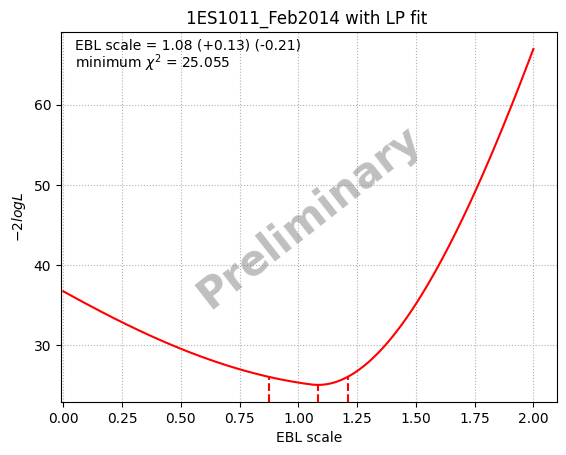

In [86]:
#plot of chi2 vs alpha
order = np.argsort(alphas)
alphas2 = np.take_along_axis(alphas, order, axis=-1)[1:-1]
chisqs2 = np.take_along_axis(np.array(chisqs), order, axis=-1)[1:-1]
interpx = np.arange(alpha_min + alpha_step, alpha_max - alpha_step, alpha_step/1000)
f1 = interpolate.interp1d(alphas2, chisqs2, kind='cubic')
chis_new = f1(interpx)
minimum = np.round(interpx[np.where(chis_new == np.min(chis_new))][0], decimals = 3)
sigma_inter_1s = np.where(chis_new <= 1 + np.min(chis_new))
upper_bound = np.round(interpx[np.max(sigma_inter_1s)], decimals = 3)
lower_bound = np.round(interpx[np.min(sigma_inter_1s)], decimals = 3)

plt.plot(alphas2, chisqs2, color = "red")
limits = plt.ylim()
limmin = limits[0]
limmax = limits[1]
maxymin = (np.min(chis_new)-limmin) / (limmax-limmin)
maxymin1 = (np.min(chis_new)+1-limmin) / (limmax-limmin)
plt.axvline(minimum, ymax = maxymin, color = "red", linestyle = "--")
plt.axvline(upper_bound, ymax = maxymin1, color = "red", linestyle = "--")
if lower_bound != 0:
    plt.axvline(lower_bound, ymax = maxymin1, color = "red", linestyle = "--")
plt.xlabel("EBL scale")
plt.ylabel(r"$-2logL$")
plt.grid(linestyle = ":")
plt.xlim(-0.01,None)
# plt.ylim(None, 20)
plt.title("{0} with {1} fit ".format(Source_name, fit_func_name))
plt.text(x = 0.05, y = np.max(chisqs2) - (np.max(chisqs2)-np.min(chisqs2))/1000, s="EBL scale = {0:.2f} (+{1:.2f}) (-{2:.2f})".format(minimum, np.round(upper_bound-minimum, decimals = 3), np.round(minimum-lower_bound, decimals = 3)))
plt.text(x = 0.05, y = np.max(chisqs2) - (np.max(chisqs2)-np.min(chisqs2))/18, s = r"minimum $\chi^2$ = {0}".format(np.round(np.min(chis_new), decimals = 3)))
plt.text(0.5, 0.5, "Preliminary", ha='center', va='center', fontsize=30, fontweight='bold',
         transform=plt.gca().transAxes, alpha=0.5, rotation=38, color='gray')
plt.savefig("chi2fits/chi2_{0}_{1}_{2}_preliminary.jpg".format(Source_name, fit_func_name, extratxt))
plt.show()


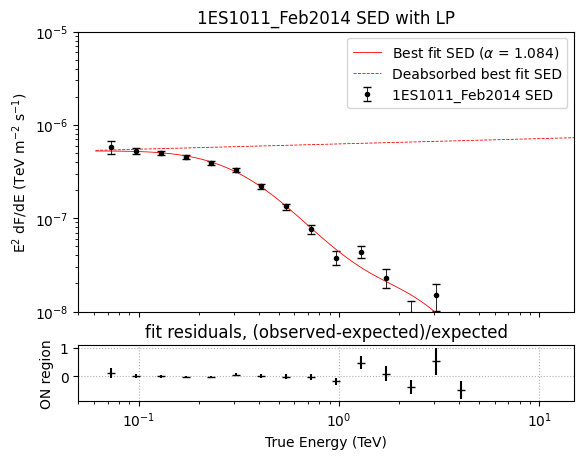

In [87]:
#FIXME change to the best fit alpha

##########for debugging#########
# bestfit = [0.00013531191468855427,-0.428440997483335,-0.29826047329296185]
# alpha = 0.15#minimum
#########################3

alpha = minimum
mtau = -tau
Data = uproot.open(data_path + ":DiffEspectrum")
Data_values = Data.values()
dNdE_u = Data.errors("mean")[1]
dNdE = Data_values[1] # 1/ cm^2 / s / TeV
Eest_data = Data_values[0] * 1e-3 #TeV
tau1 =  OptDepth.readmodel(model=EBL_Model)
mtau2 = -tau1.opt_depth(Source_z, Eest_data)
# mtau2 = -tau_interp(Eest_data, Source_z, EBL_Model, kind_of_interp = "log")#-log_interp1d(E_EBL, tau_EBL, Eest_data)
SED_orig = Eest_data * Eest_data * dNdE * 1e4 #put it in 1/m^2 instead of 1/cm^2
SED_orig_u = Eest_data *  Eest_data * dNdE_u *1e4
SED_fit = fit_func(Etrue, bestfit) * np.exp(mtau * alpha) * Etrue * Etrue
SED_fit_deabs = fit_func(Etrue, bestfit) * Etrue * Etrue
SED_fit2 = fit_func(Eest_data, bestfit) * np.exp(mtau2 * alpha) * Eest_data * Eest_data
binw = np.zeros(len(Eest)-1)

Etrue_bins = np.where((Emin <= Etrue) & (Etrue <= Emax))
minbin_tr = Etrue_bins[0][0]
maxbin_tr = Etrue_bins[0][-1] + 1

f, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [5, 1]}, sharex=True)
ax1.errorbar(Eest_data, SED_orig, yerr= SED_orig_u, fmt = ".", capsize = 3, label = "{0} SED".format(Source_name), color = "black", linewidth = 0.6)
# ax1.errorbar(Eest_final, SED_orig, yerr=SED_orig_u, fmt = ".", label = "Assimov dataset SED")
ax1.plot(Etrue[minbin_tr:maxbin_tr], SED_fit[minbin_tr:maxbin_tr], label = r"Best fit SED ($\alpha$ = {0})".format(alpha), color = 'red', linewidth = 0.6)
ax1.plot(Etrue[minbin_tr:maxbin_tr], SED_fit_deabs[minbin_tr:maxbin_tr], linestyle = "--", label = "Deabsorbed best fit SED", color = 'red', linewidth = 0.6)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xlabel("True Energy (TeV)")
ax1.set_ylabel(r"E$^2$ dF/dE (TeV m$^{-2}$ s$^{-1}$)")
ax1.set_title("{0} SED with {1}".format(Source_name, fit_func_name))
ax1.legend()
ax1.set_xlim(5e-2, 1.5e1)
ax1.set_ylim(1e-8, 1e-5)
ax2.errorbar(Eest_data, (SED_orig - SED_fit2) / SED_fit2 , yerr= SED_orig_u / SED_fit2, fmt = "_",  color = "black")
# ax2.axhline(color = "black")
ax2.set_title("fit residuals, (observed-expected)/expected")
ax2.set_ylabel("ON region")
ax2.grid(linestyle = ":")
# ax2.set_yscale('log')
plt.savefig("chi2fits/bestfitSED_{0}_{1}_{2}.pdf".format(Source_name, fit_func_name, extratxt))
plt.show()

best fit for alpha = 1: <ValueView phi0=8.85502461718794e-06 gamma0=2.0133708438875524 b=0.20099624206765077>


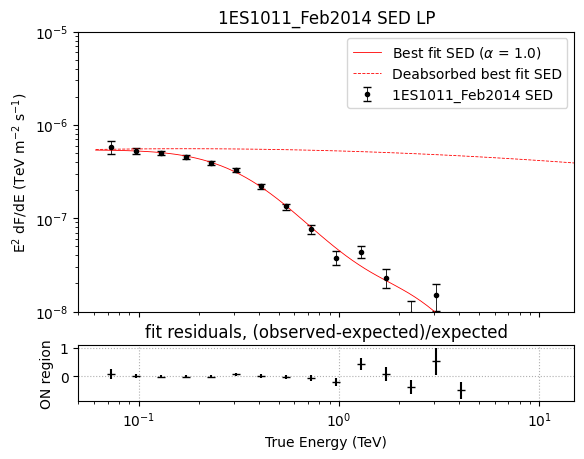

In [88]:
#best fit for alpha = 1:
print("best fit for alpha = 1:", bestfit_alpha1)
alpha = 1.
mtau = -tau
Data = uproot.open(data_path + ":DiffEspectrum")
Data_values = Data.values()
dNdE_u = Data.errors("mean")[1]
dNdE = Data_values[1] # 1/ cm^2 / s / TeV
Eest_data = Data_values[0] * 1e-3 #TeV
tau1 =  OptDepth.readmodel(model=EBL_Model)
mtau2 = -tau1.opt_depth(Source_z, Eest_data)
# mtau2 = -tau_interp(Eest_data, Source_z, EBL_Model, kind_of_interp = "log")#-log_interp1d(E_EBL, tau_EBL, Eest_data)
SED_orig = Eest_data * Eest_data * dNdE * 1e4 #put it in 1/m^2 instead of 1/cm^2
SED_orig_u = Eest_data *  Eest_data * dNdE_u *1e4
SED_fit = fit_func(Etrue, bestfit_alpha1) * np.exp(mtau * alpha) * Etrue * Etrue
SED_fit_deabs = fit_func(Etrue, bestfit_alpha1) * Etrue * Etrue
SED_fit2 = fit_func(Eest_data, bestfit_alpha1) * np.exp(mtau2 * alpha) * Eest_data * Eest_data
binw = np.zeros(len(Eest)-1)

Etrue_bins = np.where((Emin <= Etrue) & (Etrue <= Emax))
minbin_tr = Etrue_bins[0][0]
maxbin_tr = Etrue_bins[0][-1] + 1

f, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [5, 1]}, sharex=True)
ax1.errorbar(Eest_data, SED_orig, yerr= SED_orig_u, fmt = ".", capsize = 3, label = "{0} SED".format(Source_name), color = "black", linewidth = 0.6)
# ax1.errorbar(Eest_final, SED_orig, yerr=SED_orig_u, fmt = ".", label = "Assimov dataset SED")
ax1.plot(Etrue[minbin_tr:maxbin_tr], SED_fit[minbin_tr:maxbin_tr], label = r"Best fit SED ($\alpha$ = {0})".format(alpha), color = 'red', linewidth = 0.6)
ax1.plot(Etrue[minbin_tr:maxbin_tr], SED_fit_deabs[minbin_tr:maxbin_tr], linestyle = "--", label = "Deabsorbed best fit SED", color = 'red', linewidth = 0.6)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xlabel("True Energy (TeV)")
ax1.set_ylabel(r"E$^2$ dF/dE (TeV m$^{-2}$ s$^{-1}$)")
ax1.set_title("{0} SED {1}".format(Source_name, fit_func_name))
ax1.legend()
ax1.set_xlim(5e-2, 1.5e1)
ax1.set_ylim(1e-8, 1e-5)
ax2.errorbar(Eest_data, (SED_orig - SED_fit2) / SED_fit2 , yerr= SED_orig_u / SED_fit2, fmt = "_",  color = "black")
# ax2.axhline(color = "black")
ax2.set_title("fit residuals, (observed-expected)/expected")
ax2.set_ylabel("ON region")
ax2.grid(linestyle = ":")
# ax2.set_yscale('log')
plt.savefig("chi2fits/bestfit_alpha1_SED_{0}_{1}_{2}.pdf".format(Source_name, fit_func_name, extratxt))
plt.show()

## Compute residuals correctly

In [ ]:
# Emin = 0.06
# Emax = 10
# Emin = 0.045
# Emax = 12.#15.

# Usedbins = np.where((Emin <= Eest) & (Eest <= Emax))
# minbin = Usedbins[0][0]
# maxbin = Usedbins[0][-1] + 1
def Poisson_logL_Non0_IRF_mus(Non, Noff, mu_gam, delta_mu_gam, Noffregions): #canviat per IRF
    mu_bg = Noff / (1. + Noffregions)
    mu_gam2 = -np.square(delta_mu_gam) + mu_gam
    if mu_gam2 < 0.:#FIXME?
        mu_gam2 = 0
    return mu_gam2, mu_bg

def Poisson_logL_Noff0_IRF_mus(Non, Noff, mu_gam, delta_mu_gam, Noffregions):
    fAlpha = 1/Noffregions
    mu_bg = fAlpha * Non / (1 + fAlpha) - mu_gam -np.square(delta_mu_gam)/fAlpha
    if mu_bg < 0.:
        mu_bg = 0
        a = 1.
        b = -mu_gam + np.square(delta_mu_gam)
        c = -Non + np.square(delta_mu_gam)
        mu_gam2 = (-b + np.sqrt(np.square(b) - 4 * a * c)) / (2. * a)
    else:
        mu_gam2 = mu_gam + np.square(delta_mu_gam) / fAlpha
    return mu_gam2, mu_bg

def Poisson_logL_else_IRF_mus(Non, Noff, mu_gam, delta_mu_gam, Noffregions):
    mu_gam2, mu_bg = best_mubg_mugam_IRF(Non, Noff, mu_gam, delta_mu_gam, Noffregions)
    if np.isnan(mu_gam2):
        return 99999999999999
    elif mu_gam2 < 0.:
        mu_gam2 = 0
        mu_bg = (Non + Noff)/ (1 + Noffregions)
    return mu_gam2, mu_bg

def Poisson_logL_small_mugam_IRF_mus(Non, Noff, mu_gam, delta_mu_gam, Noffregions):
    fAlpha = 1/Noffregions
    mu_bg = fAlpha * (Noff + Non) / (1+fAlpha)
    return mu_gam, mu_bg


alpha = minimum
xdata = Etrue
mtau = -tau
Non, Noff = np.round(mu_on), np.round(Noffregions * mu_off) #FIXME: round?
mu_gam, mu_gam_u = dNdE_to_mu_MAGIC_IRF((fit_func(xdata, bestfit) * np.exp(mtau * alpha)), Ebinsw_Etrue, migmatval, migmaterr, Eest)
mu_gam_temp_u = mu_gam_u[minbin:maxbin]
mu_gam_temp = mu_gam[minbin:maxbin]
Non_temp = Non[minbin:maxbin]

Noff_temp = Noff[minbin:maxbin]

if betterEminmax:
    newminbin, newmaxbin = minbinmaxbinfinal(Non_temp, Noff_temp)
    Non_final = Non_temp[newminbin:newmaxbin]
    Noff_final = Noff_temp[newminbin:newmaxbin]
    mu_gam_final = mu_gam_temp[newminbin:newmaxbin]
    if IRF_u:
        mu_gam_final_u = mu_gam_temp_u[newminbin:newmaxbin]
else: 
    Non_final = Non_temp
    Noff_final = Noff_temp
    mu_gam_final = mu_gam_temp
    if IRF_u:
        mu_gam_final_u = mu_gam_temp_u
        
Non_final_u = np.sqrt(Non_final)
min_num_gauss = 20
mu_gam_f = np.zeros(len(Non_final))
mu_bg_f = np.zeros(len(Noff_final))


for i in range(len(Non_final)):
    if ((Non_final[i] >= min_num_gauss) & (Noff_final[i] >= min_num_gauss)):
        mu_gam_f[i], mu_bg_f[i] = mu_gam_final[i], Noff_final[i] / Noffregions
    elif Non_final[i] == 0:
        mu_gam_f[i], mu_bg_f[i] = Poisson_logL_Non0_IRF_mus(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)
    elif Noff_final[i] == 0:
        mu_gam_f[i], mu_bg_f[i] = Poisson_logL_Noff0_IRF_mus(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)
    elif mu_gam_final[i] < 1e-6:
        mu_gam_f[i], mu_bg_f[i] = Poisson_logL_small_mugam_IRF_mus(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)
    elif mu_gam_final_u[i] == 0:
        mu_gam_f[i], mu_bg_f[i] = mu_gam_final[i], mu_BG(mu_gam_final[i], Non_final[i], Noff_final[i], Noffregions)
    elif (Non_final[i] != 0) & (Noff_final[i] != 0):
        mu_gam_f[i], mu_bg_f[i] = Poisson_logL_else_IRF_mus(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)

mu_on_f_sim = mu_gam_f + mu_bg_f

############compute uncertainties############

def m2LogL_unc(params):
    # xdata = Etrue
    # mtau = -tau
    # if IRF_u:
    #     mu_gam, mu_gam_u = dNdE_to_mu_MAGIC_IRF((fit_func(xdata, params) * np.exp(mtau * alpha)), Ebinsw_Etrue, migmatval, migmaterr, Eest)
    #     mu_gam_final_u = mu_gam_u[minbin:maxbin]

    # else:
    #     mu_gam = dNdE_to_mu_MAGIC((fit_func(xdata, params) * np.exp(mtau * alpha)), Ebinsw_Etrue, migmatval, Eest)

    # mu_gam_final = mu_gam[minbin:maxbin]
    # Non_final = Non[minbin:maxbin] 
    # Noff_final = Noff[minbin:maxbin]
    min_num_gauss = 20

    res = np.ones(len(Non_final)) * 999999999
    for i in range(len(Non_final)):
        if IRF_u:
            if ((Non_final[i] >= min_num_gauss) & (Noff_final[i] >= min_num_gauss)):
                res[i] = Gauss_logL_IRF(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)
            elif Non_final[i] == 0:
                res[i] = Poisson_logL_Non0_IRF(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)
            elif Noff_final[i] == 0:
                res[i] = Poisson_logL_Noff0_IRF(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)
            elif mu_gam_final[i] < 1e-6:
                res[i] = Poisson_logL_small_mugam_IRF(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)
            elif mu_gam_final_u[i] == 0:
                res[i] = Poisson_logL_noIRF_IRF(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)
            elif (Non_final[i] != 0) & (Noff_final[i] != 0):
                res[i] = Poisson_logL_else_IRF(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)
        
        else:
            if ((Non_final[i] >= min_num_gauss) & (Noff_final[i] >= min_num_gauss)):
                res[i] = Gauss_logL(Non_final[i], Noff_final[i], mu_gam_final[i], Noffregions)
            elif Non_final[i] == 0:
                res[i] = Poisson_logL_Non0(Non_final[i], Noff_final[i], mu_gam_final[i], Noffregions)
            elif Noff_final[i] == 0:
                res[i] = Poisson_logL_Noff0(Non_final[i], Noff_final[i], mu_gam_final[i], Noffregions)
            elif (Non_final[i] != 0) & (Noff_final[i] != 0):
                res[i] = Poisson_logL_else(Non_final[i], Noff_final[i], mu_gam_final[i], Noffregions) 

    return res
chi2vals = m2LogL_unc(bestfit)
uncertainty = np.sqrt(chi2vals)

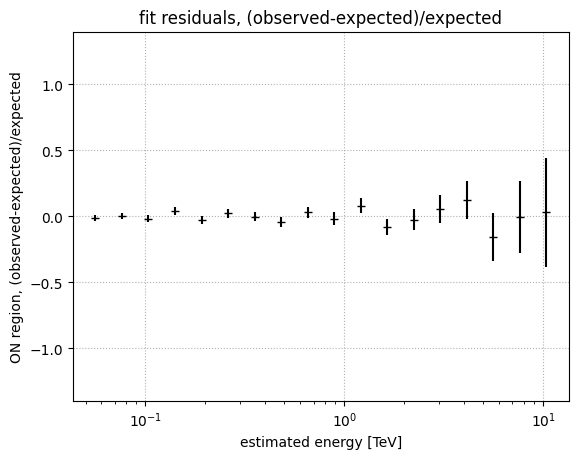

In [ ]:
#np.round(mu_on) = Non 
error = np.abs(((Non_final) / mu_on_f_sim)-1) / uncertainty
plt.errorbar(Eest[minbin:maxbin], (Non_final - mu_on_f_sim) / mu_on_f_sim , yerr= error, fmt = "_",  color = "black")
# ax2.axhline(color = "black")
plt.title("fit residuals, (observed-expected)/expected")
plt.ylabel("ON region, (observed-expected)/expected")
plt.xlabel("estimated energy [TeV]")
plt.grid(linestyle = ":")
plt.xscale('log')
plt.ylim(-1.4, 1.4)
# ax2.set_yscale('log')
plt.show()

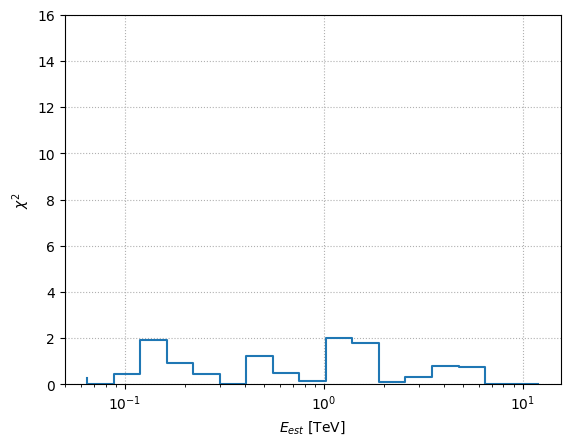

In [ ]:
####################plot ON##########
# plt.errorbar(Eest[minbin:maxbin], Non_final, yerr = np.sqrt(Non_final), label = "observed", fmt = "_",  color = "black")
# plt.errorbar(Eest[minbin:maxbin], mu_on_f_sim, label = "expected", yerr = np.sqrt(mu_on_f_sim), fmt = "_",  color = "red")
# plt.xscale('log')
# plt.yscale('log')
# plt.legend()
# plt.show()

##################plot Chi2################
newEest = migmatyEest[1:]
plt.step(newEest[minbin:maxbin], chi2vals)
plt.grid(linestyle = ":")
plt.ylabel(r"$\chi^2$")
plt.xlabel(r"$E_{est}$ [TeV]")
plt.ylim(0, 16)
plt.xscale('log')
plt.show()

In [ ]:
SED_fit = fit_func(Etrue, bestfit) * np.exp(mtau * alpha) * Etrue * Etrue
SED_fit_deabs = fit_func(Etrue, bestfit) * Etrue * Etrue
bestfit_fitebl = np.array([9.56347285014192e-06, 1.90185, 1.77207e-08])
SED_fit_fitebl = fit_func(Etrue, bestfit_fitebl) * np.exp(mtau * 1.123) * Etrue * Etrue
SED_fit_deabs_fitebl = fit_func(Etrue, bestfit_fitebl) * Etrue * Etrue

plt.errorbar(Eest_data, SED_orig, yerr= SED_orig_u, fmt = ".", capsize = 3, label = "1ES1011 SED", color = "black", linewidth = 0.6)
plt.plot(Etrue, SED_fit, label = "fit")
plt.plot(Etrue, SED_fit_fitebl, label = "fit_fitebl")
plt.plot(Etrue, SED_fit_deabs, label = "fit_deabs", linestyle = "--")
plt.plot(Etrue, SED_fit_deabs_fitebl, label = "fit_deabs_fitebl", linestyle = "--")
plt.legend()
plt.xlim(5e-2, 1.5e1)
plt.ylim(1e-10, 1e-5)
plt.xscale('log')
plt.yscale('log')
plt.show()

#[0]*pow(x/%.2f,[1]-[2]*[2]*log10(x/%.2f))
#[0]+([1]-[2]*[2]*log10(x/%.2f))*log(x/%.2f)
#phi0 * np.power((xdata/0.249), (-alpha - beta * beta * np.log10(xdata/0.249)))

IndexError: index 3 is out of bounds for axis 0 with size 3

alpha: 1.123
initial guess: [ 5.77517250e-06  2.83929152e+00 -1.00339961e+00]
alpha: 1.123
initial guess: [ 5.77517250e-06  2.83929152e+00 -1.00339961e+00]


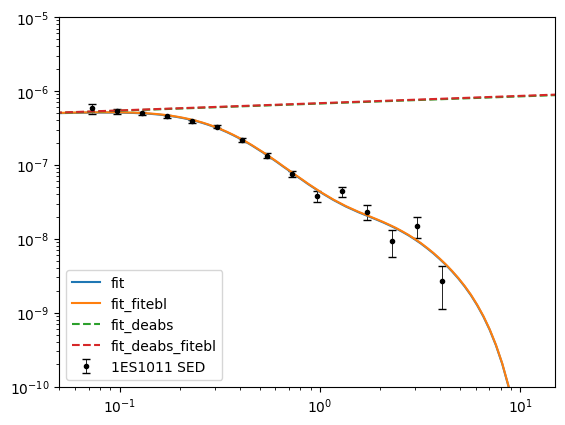

<ValueView phi0=9.462258965821694e-06 gamma0=1.9032654686456854 b=-0.0009969851472431367>
[9.56347285014192e-06, 1.90185, 1.77207e-08]
[27.72520164]
28.012349939814357


In [ ]:
chisq123, bestfit123 = process2([1.123], mu_on, mu_off)
SED_fit_123 = fit_func(Etrue, bestfit123) * np.exp(mtau * 1.123) * Etrue * Etrue
SED_fit_123_deabs = fit_func(Etrue, bestfit123) * Etrue * Etrue
bestfit_fitebl = np.array([9.56347285014192e-06, 1.90185, 1.77207e-08])
SED_fit_fitebl = fit_func(Etrue, bestfit_fitebl) * np.exp(mtau * 1.123) * Etrue * Etrue
SED_fit_deabs_fitebl = fit_func(Etrue, bestfit_fitebl) * Etrue * Etrue

plt.errorbar(Eest_data, SED_orig, yerr= SED_orig_u, fmt = ".", capsize = 3, label = "1ES1011 SED", color = "black", linewidth = 0.6)
plt.plot(Etrue, SED_fit_123, label = "fit")
plt.plot(Etrue, SED_fit_fitebl, label = "fit_fitebl")
plt.plot(Etrue, SED_fit_123_deabs, label = "fit_deabs", linestyle = "--")
plt.plot(Etrue, SED_fit_deabs_fitebl, label = "fit_deabs_fitebl", linestyle = "--")
plt.legend()
plt.xlim(5e-2, 1.5e1)
plt.ylim(1e-10, 1e-5)
plt.xscale('log')
plt.yscale('log')
plt.show()
print(bestfit123)
print([9.56347285014192e-06, 1.90185, 1.77207e-08])
print(chisq123)
print(m2LogL([9.56347285014192e-06, 1.90185, 1.77207e-08]))

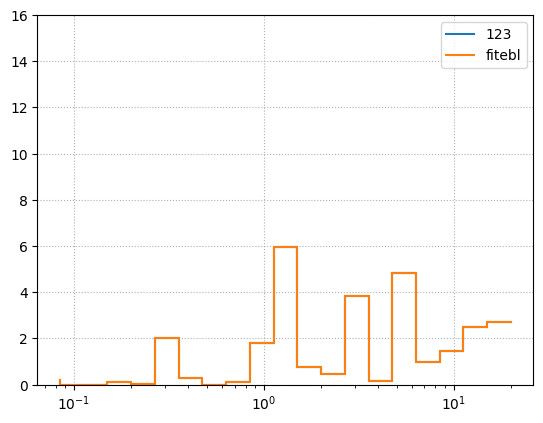

[ 0.07379243  0.09840378  0.13122355  0.17498942  0.23335214  0.31118008
  0.41496531  0.55336514  0.73792427  0.98403783  1.31223553  1.74989421
  2.33352143  3.11180084  4.14965312  5.53365137  7.37924269  9.84037829
 13.12235535 17.49894209] [2.05518491e-01 5.18586941e-03 4.37544819e-03 1.31827581e-01
 4.99120267e-02 2.00965314e+00 2.77909608e-01 1.22337718e-03
 1.12773509e-01 1.82082603e+00 5.97710163e+00 7.45051886e-01
 4.44638595e-01 3.82954349e+00 1.42742916e-01 4.82092399e+00
 9.90016462e-01 1.45897591e+00 2.50696510e+00 2.71739404e+00]


In [ ]:
chi2vals_fitebl = m2LogL_unc([9.56347285014192e-06, 1.90185, 1.77207e-08])
chi2vals_123 = m2LogL_unc(bestfit123)
plt.step(newEest[minbin:maxbin], chi2vals_123, label = "123")
plt.step(newEest[minbin:maxbin], chi2vals_fitebl, label = "fitebl")
plt.grid(linestyle = ":")
plt.ylim(0, 16)
plt.xscale('log')
plt.legend()
plt.show()
print(Eest[minbin:maxbin],chi2vals_fitebl)

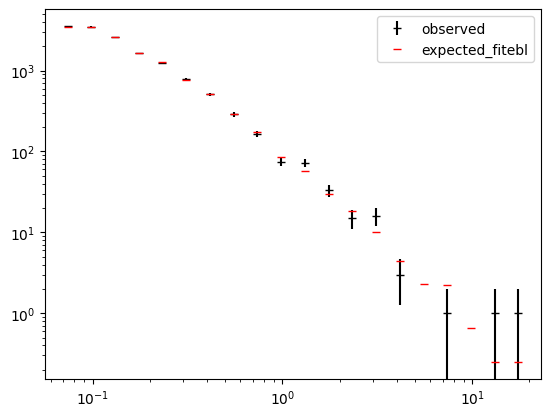

[3.48882536e+03 3.46729410e+03 2.58055771e+03 1.65870524e+03
 1.27136942e+03 7.67698057e+02 5.08681164e+02 2.93755410e+02
 1.72329173e+02 8.65764991e+01 5.71211673e+01 2.99602986e+01
 1.82825954e+01 1.00959385e+01 4.45600915e+00 2.30640312e+00
 2.23293368e+00 6.63150590e-01 2.50000000e-01 2.50000000e-01]


In [ ]:
def mu_on_comp(alpha, bestfit):
    xdata = Etrue
    mtau = -tau
    Non, Noff = np.round(mu_on), np.round(Noffregions * mu_off) #FIXME: round?
    mu_gam, mu_gam_u = dNdE_to_mu_MAGIC_IRF((fit_func(xdata, bestfit) * np.exp(mtau * alpha)), Ebinsw_Etrue, migmatval, migmaterr, Eest)
    mu_gam_final_u = mu_gam_u[minbin:maxbin]
    mu_gam_final = mu_gam[minbin:maxbin]
    Non_final = Non[minbin:maxbin] 
    Non_final_u = np.sqrt(Non_final)
    Noff_final = Noff[minbin:maxbin]
    min_num_gauss = 20
    mu_gam_f = np.zeros(len(Non_final))
    mu_bg_f = np.zeros(len(Noff_final))

    for i in range(len(Non_final)):
        if ((Non_final[i] >= min_num_gauss) & (Noff_final[i] >= min_num_gauss)):
            mu_gam_f[i], mu_bg_f[i] = mu_gam_final[i], (Non_final[i] - mu_gam_final[i] + Noff_final[i]) / (1 + Noffregions) #(observed-expectedgammas + numoffevents) / (1.+1./fAlpha)
        elif Non_final[i] == 0:
            mu_gam_f[i], mu_bg_f[i] = Poisson_logL_Non0_IRF_mus(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)
        elif Noff_final[i] == 0:
            mu_gam_f[i], mu_bg_f[i] = Poisson_logL_Noff0_IRF_mus(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)
        elif mu_gam_final[i] < 1e-6:
            mu_gam_f[i], mu_bg_f[i] = Poisson_logL_small_mugam_IRF_mus(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)
        elif mu_gam_final_u[i] == 0:
            mu_gam_f[i], mu_bg_f[i] = mu_gam_final[i], mu_BG(mu_gam_final[i], Non_final[i], Noff_final[i], Noffregions)
        elif (Non_final[i] != 0) & (Noff_final[i] != 0):
            mu_gam_f[i], mu_bg_f[i] = Poisson_logL_else_IRF_mus(Non_final[i], Noff_final[i], mu_gam_final[i], mu_gam_final_u[i], Noffregions)

    mu_on_f_sim = mu_gam_f + mu_bg_f
    return mu_on_f_sim

ON_f123 = mu_on_comp(1.123, bestfit123)
ON_fitebl = mu_on_comp(1.123, bestfit_fitebl)

plt.errorbar(Eest[minbin:maxbin], Non_final, yerr = np.sqrt(Non_final), label = "observed", fmt = "_",  color = "black")
# plt.errorbar(Eest[minbin:maxbin], ON_f123, label = "expected_123", yerr = np.sqrt(ON_f123), fmt = "_",  color = "orange")
plt.errorbar(Eest[minbin:maxbin], ON_fitebl, label = "expected_fitebl", fmt = "_",  color = "red")

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()
print(ON_fitebl)

## Now plot it with the SED (more SED points missing)

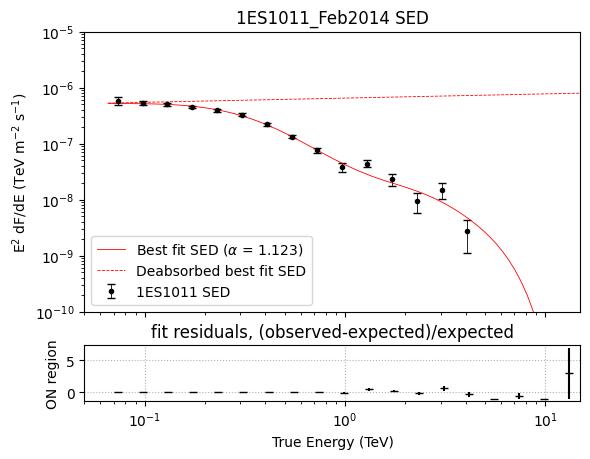

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [5, 1]}, sharex=True)
ax1.errorbar(Eest_data, SED_orig, yerr= SED_orig_u, fmt = ".", capsize = 3, label = "1ES1011 SED", color = "black", linewidth = 0.6)
# ax1.errorbar(Eest_final, SED_orig, yerr=SED_orig_u, fmt = ".", label = "Assimov dataset SED")
ax1.plot(Etrue[minbin_tr:maxbin_tr], SED_fit[minbin_tr:maxbin_tr], label = r"Best fit SED ($\alpha$ = {0})".format(alpha), color = 'red', linewidth = 0.6)
ax1.plot(Etrue[minbin_tr:maxbin_tr], SED_fit_deabs[minbin_tr:maxbin_tr], linestyle = "--", label = "Deabsorbed best fit SED", color = 'red', linewidth = 0.6)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xlabel("True Energy (TeV)")
ax1.set_ylabel(r"E$^2$ dF/dE (TeV m$^{-2}$ s$^{-1}$)")
ax1.set_title("{0} SED".format(Source_name))
ax1.legend()
ax1.set_xlim(5e-2, 1.5e1)
ax1.set_ylim(1e-10, 1e-5)
ax2.errorbar(Eest[minbin:maxbin], (Non_final - mu_on_f_sim) / mu_on_f_sim , yerr= Non_final_u / mu_on_f_sim, fmt = "_",  color = "black")
# ax2.axhline(color = "black")
ax2.set_title("fit residuals, (observed-expected)/expected")
ax2.set_ylabel("ON region")
ax2.grid(linestyle = ":")
# ax2.set_yscale('log')
plt.show()

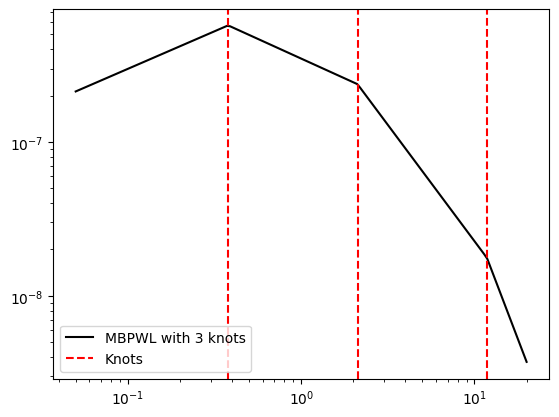

In [ ]:
MBPWL = fit_func_select("MBPWL", knots = 3, Efirst = Efirst, DeltaE = DeltaE+2)
Energy_plot = np.geomspace(5e-2, 2.e1, 150)
Ebr = np.geomspace(Efirst, Efirst+ DeltaE+2, 3)
SED_fitplot = MBPWL(Energy_plot, np.array([7.471428040974111e-06, 1.5119396033218624, 1., 1., 1.2])) * np.square(Energy_plot)
plt.plot(Energy_plot, SED_fitplot, color = 'black', label = "MBPWL with 3 knots")
plt.axvline(Efirst, label = "Knots", color = "red", linestyle = "--")
plt.axvline(Ebr[1], color = "red", linestyle = "--")
plt.axvline(Ebr[2], color = "red", linestyle = "--")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

Example of EBL absorption:

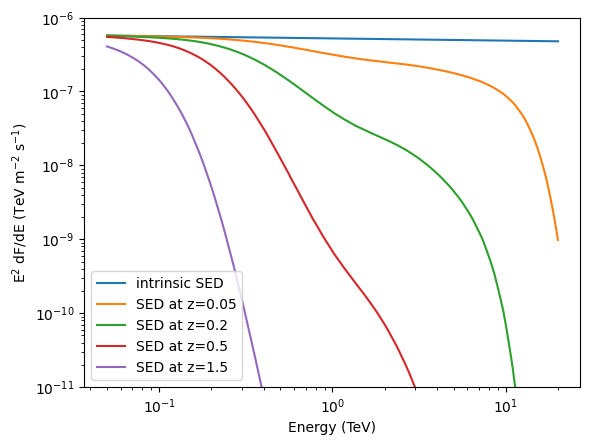

In [ ]:
redshifts = [0., 0.05, 0.2, 0.5, 1.5]
PWL = fit_func_select("PWL")
Energy_plot = np.geomspace(5e-2, 2.e1, 150)
for i in redshifts:
    if i == 0.:
        SED_plot = PWL(Energy_plot, [8.7e-6, 2.03]) * np.square(Energy_plot)
        plt.plot(Energy_plot, SED_plot, label = 'intrinsic SED'.format(i))
    else:
        tau2 = tau_interp(Energy_plot, i, "Dominguez", kind_of_interp = "log")
        SED_plot = PWL(Energy_plot, [8.7e-6, 2.03]) * np.exp(-tau2) * np.square(Energy_plot)
        plt.plot(Energy_plot, SED_plot, label = 'SED at z={0}'.format(i))

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-11, 1e-6)
plt.xlabel('Energy (TeV)')
plt.ylabel(r"E$^2$ dF/dE (TeV m$^{-2}$ s$^{-1}$)")
plt.show()

### Now for summing some $\chi ^2$ plots

16


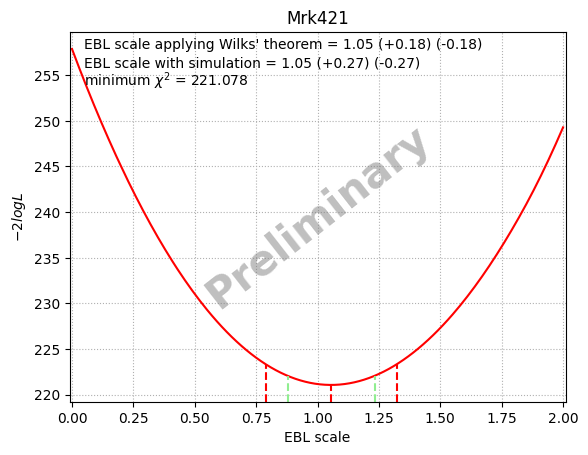

In [103]:
#plot of chi2 vs alpha
def extract(ds):
    chisqs = ds['chisqs'][:]
    alphas = ds['alphas'][:]
    return chisqs,alphas

extratxtpic = "all" #n_gamma, SED, time.
extratxt = "test_systematics"#"test_systematics"#"morebins"
source = "Mrk421"
pathstring = "/home/rgrau/Desktop/EBL_pic_sync/"
locname = pathstring + 'chi2fits'
loc = Path(locname)

# files = sorted([f for f in loc.glob("EBL*2022050916*.hdf5")]) #PWL_LP starting at alpha = 1 (16 alpha = 1, 11 alpha = 2)
files = sorted([f for f in loc.glob("chi2_{0}*_{1}.hdf5".format(source, extratxt))])
chisqs_iter = []
alphas_iter = []
# print(len(files))
for name in files:
    if "SUM" not in str(name):
        fileop = h5py.File(name, "r")
        if 'chisqs' in fileop:
            chisqs, alphas = extract(fileop)
            chisqs_iter.append(chisqs)
            alphas_iter.append(alphas)
        fileop.close()
alphas = alphas_iter[0]
chisqs_sum = np.sum(chisqs_iter, axis = 0)

order = np.argsort(alphas)
alphas2 = np.take_along_axis(alphas, order, axis=-1)
chisqs2 = np.take_along_axis(chisqs_sum, order, axis=-1)
interpx = np.arange(alpha_min + alpha_step, alpha_max - alpha_step, alpha_step/1000)
f1 = interpolate.interp1d(alphas2, chisqs2, kind='cubic')
chis_new = f1(interpx)
minimum = interpx[np.where(chis_new == np.min(chis_new))][0]

onesigma_delta = 2.2664075178519774 #3.526

sigma_inter_1s_default = np.where(chis_new <= 1 + np.min(chis_new))
upper_bound_default = np.round(interpx[np.max(sigma_inter_1s_default)], decimals = 3)
lower_bound_default = np.round(interpx[np.min(sigma_inter_1s_default)], decimals = 3)

sigma_inter_1s_real = np.where(chis_new <= onesigma_delta + np.min(chis_new))
upper_bound_real = np.round(interpx[np.max(sigma_inter_1s_real)], decimals = 3)
lower_bound_real = np.round(interpx[np.min(sigma_inter_1s_real)], decimals = 3)

hdf5filename = "chi2fits/chi2_{0}_SUM_{1}_{2}.hdf5".format("Mrk421", extratxtpic, extratxt)
savefile = h5py.File(hdf5filename, "w")
dset = savefile.create_dataset("alphas", data = alphas2, dtype='float')
dset = savefile.create_dataset("chisqs", data = chisqs2, dtype='float')
savefile.close()

plt.plot(alphas2, chisqs2, color = "red")
limits = plt.ylim()
limmin = limits[0]
limmax = limits[1]
maxymin = (np.min(chis_new)-limmin) / (limmax-limmin)
maxymin1 = (np.min(chis_new)+1-limmin) / (limmax-limmin)
maxmin_real = (np.min(chis_new)+onesigma_delta-limmin) / (limmax-limmin)
plt.axvline(minimum, ymax = maxymin, color = "red", linestyle = "--")
plt.axvline(upper_bound_real, ymax = maxmin_real, color = "red", linestyle = "--")
plt.axvline(upper_bound_default, ymax = maxymin1, color = "lightgreen", linestyle = "--")
if lower_bound_real != 0:
    plt.axvline(lower_bound_real, ymax = maxmin_real, color = "red", linestyle = "--")
if lower_bound_default != 0:
    plt.axvline(lower_bound_default, ymax = maxymin1, color = "lightgreen", linestyle = "--")
plt.xlabel("EBL scale")
plt.ylabel(r"$-2log L$")
plt.grid(linestyle = ":")
plt.xlim(-0.01,2.01)
plt.title("{0}".format(source))
plt.text(x = 0.05, y = np.max(chisqs2) - (np.max(chisqs2)-np.min(chisqs2))/1000, s="EBL scale applying Wilks' theorem = {0:.2f} (+{1:.2f}) (-{2:.2f})".format(minimum, np.round(upper_bound_default-minimum, decimals = 3), np.round(minimum-lower_bound_default, decimals = 3)))
plt.text(x = 0.05, y = np.max(chisqs2) - (np.max(chisqs2)-np.min(chisqs2))/18, s="EBL scale with simulation = {0:.2f} (+{1:.2f}) (-{2:.2f})".format(minimum, np.round(upper_bound_real-minimum, decimals = 3), np.round(minimum-lower_bound_real, decimals = 3)))
plt.text(x = 0.05, y = np.max(chisqs2) - (np.max(chisqs2)-np.min(chisqs2))/9, s = r"minimum $\chi^2$ = {0}".format(np.round(np.min(chis_new), decimals = 3)))
plt.text(0.5, 0.5, "Preliminary", ha='center', va='center', fontsize=30, fontweight='bold',
         transform=plt.gca().transAxes, alpha=0.5, rotation=38, color='gray')

plt.savefig("chi2fits/chi2_{0}_SUM_{1}_{2}_preliminary.jpg".format("Mrk_421", extratxtpic, extratxt))
plt.show()


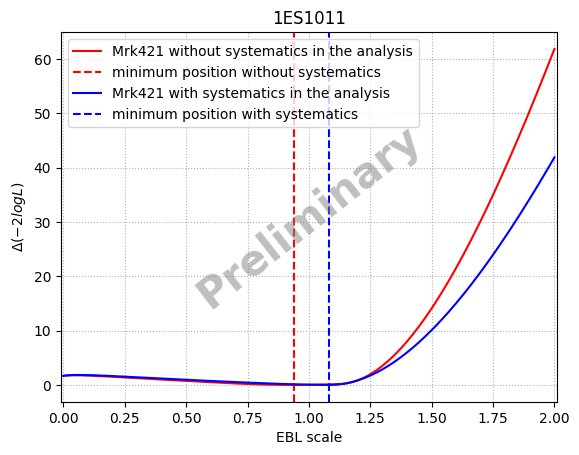

P-value without systematics = 0.024681866590361756
P-value with systematics = 0.049191995260406296


In [91]:
extratxtpic = "all" #n_gamma, SED, time.
extratxt1 = "test_no_systematics"#"test_systematics"
extratxt2 = "test_systematics"
source = "1ES1011"
pathstring = "/home/rgrau/Desktop/EBL_pic_sync/"
locname = pathstring + 'chi2fits/'
loc = Path(locname)

# files = sorted([f for f in loc.glob("EBL*2022050916*.hdf5")]) #PWL_LP starting at alpha = 1 (16 alpha = 1, 11 alpha = 2)
file1 = sorted([f for f in loc.glob("chi2_1ES1011_Feb2014_MBPWL_test_no_systematics.hdf5")])   #("chi2_{0}_SUM_{1}_{2}.hdf5".format(source, extratxtpic, extratxt1))])
file2 = sorted([f for f in loc.glob("chi2_1ES1011_Feb2014_MBPWL_test_systematics.hdf5")])#("chi2_{0}_SUM_{1}_{2}.hdf5".format(source, extratxtpic, extratxt2))])

fileop1 = h5py.File(file1[0], "r")
if 'chisqs' in fileop1:
    chisqs1, alphas1 = extract(fileop1)
fileop.close()

fileop2 = h5py.File(file2[0], "r")
if 'chisqs' in fileop2:
    chisqs2, alphas2 = extract(fileop2)
fileop.close()

plt.plot(alphas1, chisqs1-np.min(chisqs1), color = "red", label = "Mrk421 without systematics in the analysis")
plt.axvline(x = alphas1[np.where(chisqs1==np.min(chisqs1))], color = "red", linestyle = "--", label = "minimum position without systematics")
plt.plot(alphas2, chisqs2-np.min(chisqs2), color = "blue", label = "Mrk421 with systematics in the analysis")
plt.axvline(x = alphas2[np.where(chisqs2==np.min(chisqs2))], color = "blue", linestyle = "--", label = "minimum position with systematics")
plt.text(0.5, 0.5, "Preliminary", ha='center', va='center', fontsize=30, fontweight='bold',
         transform=plt.gca().transAxes, alpha=0.5, rotation=38, color='gray')
plt.legend()
plt.xlabel("EBL scale")
plt.ylabel(r"$\Delta(-2logL)$")
plt.grid(linestyle = ":")  
plt.xlim(-0.01,2.01)
plt.title("{0}".format(source))
plt.show()
nbins = len(Eest_final)
freeparams = 1 + 4
# print("nbins = {0}".format(nbins))
print("P-value without systematics = {0}".format(1 - chi2.cdf(np.min(chisqs1), nbins - freeparams)))
print("P-value with systematics = {0}".format(1 - chi2.cdf(np.min(chisqs2), nbins - freeparams)))

Number of free parameters of Mrk421_20130410 = 3.0
Number of bins of Mrk421_20130410 = 16.0
Eest of Mrk421_20130410 = [0.07624619 0.10364574 0.1408915  0.19152177 0.26034634 0.35390346
 0.48108093 0.65396043 0.8889653  1.20842066 1.64267434 2.23297986
 3.03541545 4.12621139 5.60899182 7.62461888]
Ndof of Mrk421_20130410 = 13.0
Number of free parameters of Mrk421_20130411 = 4.0
Number of bins of Mrk421_20130411 = 19.0
Eest of Mrk421_20130411 = [ 0.05608992  0.07624619  0.10364574  0.1408915   0.19152177  0.26034634
  0.35390346  0.48108093  0.65396043  0.8889653   1.20842066  1.64267434
  2.23297986  3.03541545  4.12621139  5.60899182  7.62461888 10.36457441
 14.08915046]
Ndof of Mrk421_20130411 = 15.0
Number of free parameters of Mrk421_20130412 = 3.0
Number of bins of Mrk421_20130412 = 19.0
Eest of Mrk421_20130412 = [ 0.05608992  0.07624619  0.10364574  0.1408915   0.19152177  0.26034634
  0.35390346  0.48108093  0.65396043  0.8889653   1.20842066  1.64267434
  2.23297986  3.03541545 

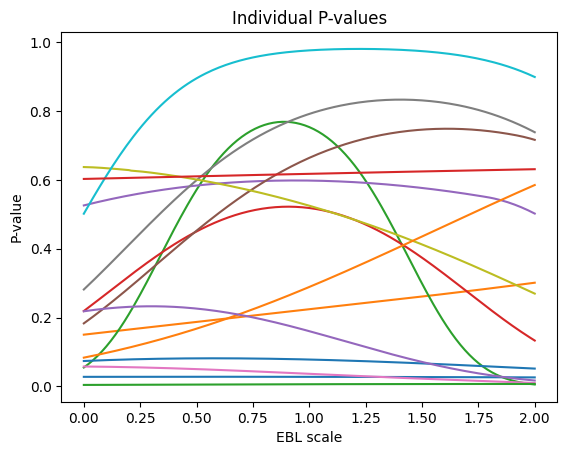

In [7]:
#P-values:
nbins = np.zeros(15)
nfreeparams = np.zeros(15)
ind_P_vals = []
totalnbins = 0
totalfreeparams = 0

for i, name in enumerate(files):
    Source_name = allsources[i]
    emin, emax = Mrk421_eminemax[i]
    func_name = Mrk421_func[i]
    if func_name == "PWL":
        nfreeparams[i] = 2 
    elif func_name == "LP" or func_name == "EPWL":
        nfreeparams[i] = 3
    elif func_name == "ELP" or func_name == "SEPWL":
        nfreeparams[i] = 4
    print("Number of free parameters of {0} = {1}".format(Source_name, nfreeparams[i]))
    migrmatrix = uproot.open("/home/rgrau/Desktop/EBL-splines/fold_migmatrix_{0}.root:mig_matrix".format(Source_name))
    Eest = migrmatrix.axis("y").centers()/1e3 
    Usedbins = np.where((emin <= Eest) & (Eest <= emax))
    minbin = Usedbins[0][0]
    maxbin = Usedbins[0][-1] + 1
    Eest_final = Eest[minbin:maxbin]
    nbins[i] = len(Eest_final)
    print("Number of bins of {0} = {1}".format(Source_name, nbins[i]))
    print("Eest of {0} = {1}".format(Source_name, Eest_final))
    fileop = h5py.File(name, "r")
    if 'chisqs' in fileop:
        chisqs, alphas = extract(fileop)
    ind_P_vals.append(1 - chi2.cdf(chisqs, nbins[i] - nfreeparams[i]))
    print("Ndof of {0} = {1}".format(Source_name, nbins[i] - nfreeparams[i]))
    fileop.close()
    totalnbins += nbins[i]
    totalfreeparams += nfreeparams[i]
    plt.plot(alphas, ind_P_vals[i], label = "{0}".format(Source_name))
plt.xlabel("EBL scale")
plt.ylabel("P-value")
plt.title("Individual P-values")
plt.show()

221.0


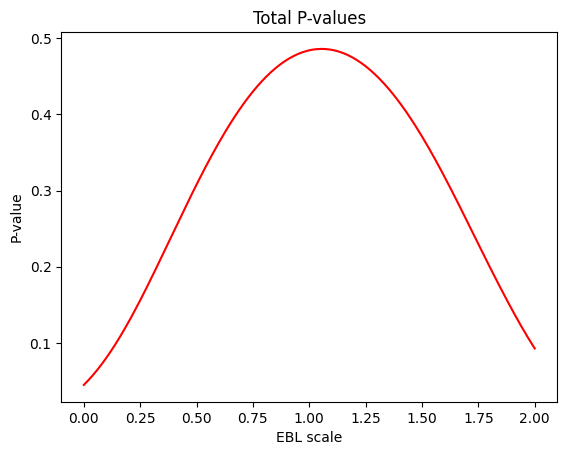

best P-value: 0.48585047710673546


In [156]:
sumPval = 1 - chi2.cdf(chisqs2, totalnbins - totalfreeparams)
print(totalnbins - totalfreeparams)
plt.plot(alphas2, sumPval, color = "red")
plt.xlabel("EBL scale")
plt.ylabel("P-value")
plt.title("Total P-values")
plt.show()
print("best P-value: {0}".format(np.max(sumPval)))

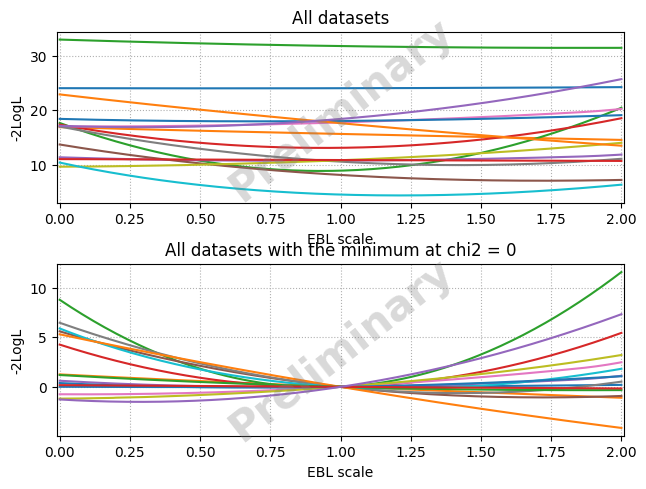

In [179]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title("All datasets")
ax2.set_title("All datasets with the minimum at chi2 = 0")
plt.tight_layout()
ax1.set_xlabel("EBL scale")
ax1.set_ylabel(r"-2LogL")
ax1.grid(linestyle = ":")
ax1.set_xlim(-0.01,2.01)
ax1.text(0.5, 1.9, "Preliminary", ha='center', va='center', fontsize=30, fontweight='bold',
         transform=plt.gca().transAxes, alpha=0.3, rotation=38, color='gray')
ax2.text(0.5, 0.5, "Preliminary", ha='center', va='center', fontsize=30, fontweight='bold',
         transform=plt.gca().transAxes, alpha=0.3, rotation=38, color='gray')
ax2.set_xlabel("EBL scale")
ax2.set_ylabel(r"-2LogL")
ax2.grid(linestyle = ":")
ax2.set_xlim(-0.01,2.01)


for name in files:
    
    fileop = h5py.File(name, "r")
    if 'chisqs' in fileop:
        chisqs, alphas = extract(fileop)
        order = np.argsort(alphas)
        if len(chisqs) == 43:
            alphas2 = np.take_along_axis(alphas, order, axis=-1)[1:-1]
            chisqs2 = np.take_along_axis(chisqs, order, axis=-1)[1:-1]
        else:           
            alphas2 = np.take_along_axis(alphas, order, axis=-1)
            chisqs2 = np.take_along_axis(chisqs, order, axis=-1)
        ax1.plot(alphas2, chisqs2, label = name)

        # ax1.legend()

        ax2.plot(alphas2, chisqs2-chisqs2[np.where(alphas2 == 1)], label = name)

        # ax2.legend()

plt.show()

In [164]:
alphas2

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09,
       1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 ,
       1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31,
       1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42,
       1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.

### Now let's sum only a selection

15


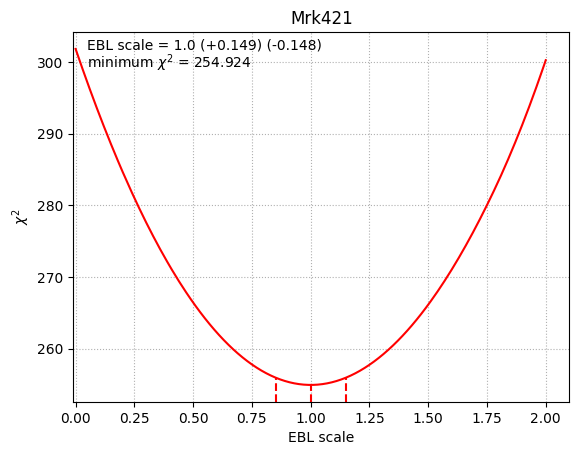

In [115]:
#plot of chi2 vs alpha
def extract(ds):
    chisqs = ds['chisqs'][:]
    alphas = ds['alphas'][:]
    return chisqs,alphas
#"Mrk421_20130410", "Mrk421_20130411", "Mrk421_20130412", "Mrk421_20130413a", "Mrk421_20130413b", "Mrk421_20130413c",
    # "Mrk421_20130414", "Mrk421_20130415a", "Mrk421_20130415b", "Mrk421_20130415c", "Mrk421_20130416", "Mrk421_20130417",
    # "Mrk421_20130418", "Mrk421_20130419", "Mrk421_20140426"
extratxt = "SED" #n_gamma, SED, time.
selected = ["0410", "0411", "0412","0413a", "0413b", "0413c", "0414", "0415a", "0415b", "0415c","0416", "0426"]

source = "Mrk421"
pathstring = "/home/rgrau/Desktop/EBL_pic_sync/"
locname = pathstring + 'chi2fits'
loc = Path(locname)

# files = sorted([f for f in loc.glob("EBL*2022050916*.hdf5")]) #PWL_LP starting at alpha = 1 (16 alpha = 1, 11 alpha = 2)
files = sorted([f for f in loc.glob("chi2_{0}*_morebins.hdf5".format(source))])
chisqs_iter = []
alphas_iter = []
print(len(files))
for name in files:
    fileop = h5py.File(name, "r")
    for sel in selected:
        if sel in str(name):
            if 'chisqs' in fileop:
                chisqs, alphas = extract(fileop)
                chisqs_iter.append(chisqs)
                alphas_iter.append(alphas)

alphas = alphas_iter[0]
chisqs_sum = np.sum(chisqs_iter, axis = 0)

order = np.argsort(alphas)
alphas2 = np.take_along_axis(alphas, order, axis=-1)
chisqs2 = np.take_along_axis(chisqs_sum, order, axis=-1)
interpx = np.arange(alpha_min + alpha_step, alpha_max - alpha_step, alpha_step/1000)
f1 = interpolate.interp1d(alphas2, chisqs2, kind='cubic')
chis_new = f1(interpx)
minimum = np.round(interpx[np.where(chis_new == np.min(chis_new))][0], decimals = 3)
sigma_inter_1s = np.where(chis_new <= 1 + np.min(chis_new))
upper_bound = np.round(interpx[np.max(sigma_inter_1s)], decimals = 3)
lower_bound = np.round(interpx[np.min(sigma_inter_1s)], decimals = 3)

plt.plot(alphas2, chisqs2, color = "red")
limits = plt.ylim()
limmin = limits[0]
limmax = limits[1]
maxymin = (np.min(chis_new)-limmin) / (limmax-limmin)
maxymin1 = (np.min(chis_new)+1-limmin) / (limmax-limmin)
plt.axvline(minimum, ymax = maxymin, color = "red", linestyle = "--")
plt.axvline(upper_bound, ymax = maxymin1, color = "red", linestyle = "--")
if lower_bound != 0:
    plt.axvline(lower_bound, ymax = maxymin1, color = "red", linestyle = "--")
plt.xlabel("EBL scale")
plt.ylabel(r"$\chi^2$")
plt.grid(linestyle = ":")
plt.xlim(-0.01,None)
plt.title("{0}".format(source))
plt.text(x = 0.05, y = np.max(chisqs2) - (np.max(chisqs2)-np.min(chisqs2))/1000, s="EBL scale = {0} (+{1}) (-{2})".format(minimum, np.round(upper_bound-minimum, decimals = 3), np.round(minimum-lower_bound, decimals = 3)))
plt.text(x = 0.05, y = np.max(chisqs2) - (np.max(chisqs2)-np.min(chisqs2))/18, s = r"minimum $\chi^2$ = {0}".format(np.round(np.min(chis_new), decimals = 3)))
plt.savefig("chi2fits/chi2_{0}_SUM_{1}_morebins.pdf".format(source, extratxt))
plt.show()


In [ ]:
files = sorted([f for f in loc.glob("chi2_{0}*.hdf5".format(source))])
test_list = ["0411", "0412","0413a", "0413c", "0414", "0415c","0416", "0426"]
files2 = sorted([f for f in loc.glob("chi2_{0}*.hdf5".format(source)) if [g for g in test_list if(g in str(f))]])
files2

[PosixPath('/home/rgrau/Desktop/EBL_pic_sync/chi2fits/chi2_Mrk421_20130411_SEPWL.hdf5'),
 PosixPath('/home/rgrau/Desktop/EBL_pic_sync/chi2fits/chi2_Mrk421_20130412_EPWL.hdf5'),
 PosixPath('/home/rgrau/Desktop/EBL_pic_sync/chi2fits/chi2_Mrk421_20130413a_EPWL.hdf5'),
 PosixPath('/home/rgrau/Desktop/EBL_pic_sync/chi2fits/chi2_Mrk421_20130413c_ELP.hdf5'),
 PosixPath('/home/rgrau/Desktop/EBL_pic_sync/chi2fits/chi2_Mrk421_20130414_ELP.hdf5'),
 PosixPath('/home/rgrau/Desktop/EBL_pic_sync/chi2fits/chi2_Mrk421_20130415c_ELP.hdf5'),
 PosixPath('/home/rgrau/Desktop/EBL_pic_sync/chi2fits/chi2_Mrk421_20130416_ELP.hdf5'),
 PosixPath('/home/rgrau/Desktop/EBL_pic_sync/chi2fits/chi2_Mrk421_20140426_EPWL.hdf5')]